In [74]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from keras import optimizers
import matplotlib.pyplot as plt; import numpy as np
import matplotlib.image as mpimg
import cv2

In [75]:
#get_bd.py
#url="http://www.lps.usp.br/hae/psi3472/ep-2020/feiFrontG2C.zip"
#import os; nomeArq=os.path.split(url)[1]
#if not os.path.exists(nomeArq):
#    print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
#    os.system("wget -nc -U 'Firefox/50.0' "+url)
#else:
#    print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
#print("Descompactando arquivos novos de",nomeArq)
#os.system("unzip -u "+nomeArq

In [76]:
# Funções de leitura das imagens e criação dos tensores de dados
def readTrain():
    n = 150
    rows = 384
    columns = 256
    AX=np.empty((2*n,rows,columns), dtype='uint8')
    AY=np.empty((2*n,rows,columns,3), dtype='uint8')
    
    k = 0
    for i in range(n):
        if(i < 9):
            ac = "Images/00" + str(i+1) + "ac" + "." + "jpg"
            al = "Images/00" + str(i+1) + "al" + "." + "jpg"
            bc = "Images/00" + str(i+1) + "bc" + "." + "jpg"
            bl = "Images/00" + str(i+1) + "bl" + "." + "jpg"
        elif(9 <= i < 99):
            ac = "Images/0" + str(i+1) + "ac" + "." + "jpg"
            al = "Images/0" + str(i+1) + "al" + "." + "jpg"
            bc = "Images/0" + str(i+1) + "bc" + "." + "jpg"
            bl = "Images/0" + str(i+1) + "bl" + "." + "jpg"
        else:
            ac = "Images/" + str(i+1) + "ac" + "." + "jpg"
            al = "Images/" + str(i+1) + "al" + "." + "jpg"
            bc = "Images/" + str(i+1) + "bc" + "." + "jpg"
            bl = "Images/" + str(i+1) + "bl" + "." + "jpg"
        
        AX[k,:,:] = cv2.imread(al, cv2.IMREAD_GRAYSCALE)
        AY[k,:,:,:] = cv2.imread(ac, cv2.IMREAD_COLOR)
        AX[k+1,:,:] = cv2.imread(bl, cv2.IMREAD_GRAYSCALE)
        AY[k+1,:,:,:] = cv2.imread(bc, cv2.IMREAD_COLOR)
        
        k = k+2
    
    return AX, AY
        
def readTest():
    n = 50
    rows = 384
    columns = 256
    
    QX=np.empty((2*n,rows,columns), dtype='uint8')
    QY=np.empty((2*n,rows,columns,3), dtype='uint8')
    
    k = 0
    for i in range(150, 200):
        ac = "Images/" + str(i+1) + "ac" + "." + "jpg"
        al = "Images/" + str(i+1) + "al" + "." + "jpg"
        bc = "Images/" + str(i+1) + "bc" + "." + "jpg"
        bl = "Images/" + str(i+1) + "bl" + "." + "jpg" 

        QY[k,:,:,:] = cv2.imread(ac,cv2.IMREAD_COLOR)
        QX[k,:,:] = cv2.imread(al,cv2.IMREAD_GRAYSCALE)
        QY[k+1,:,:,:] = cv2.imread(bc,cv2.IMREAD_COLOR)
        QX[k+1,:,:] = cv2.imread(bl,cv2.IMREAD_GRAYSCALE)
        
        k = k+2
    
    return QX, QY

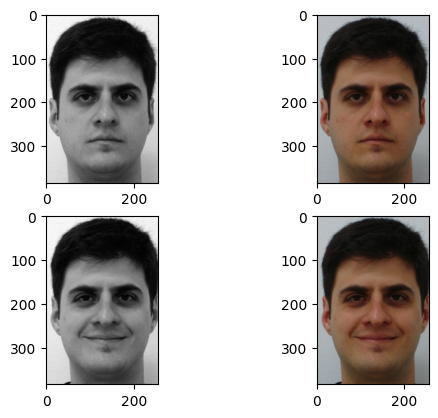

In [77]:
# Realizando a leitura das imagens
AX, AY = readTrain()
QX, QY = readTest()

# Imprimindo as imagens para verficação
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(AX[0], cmap='gray')
rgb=cv2.cvtColor(AY[0], cv2.COLOR_BGR2RGB)
axs[0,1].imshow(rgb)
axs[1,0].imshow(AX[1], cmap='gray')
rgb1=cv2.cvtColor(AY[1], cv2.COLOR_BGR2RGB)
axs[1,1].imshow(rgb1)

In [78]:
# Passando os dados para float32
ax = np.float32(AX.copy())
qx = np.float32(QX.copy())
ay = np.empty((AY.shape[0], AY.shape[1], AY.shape[2], AY.shape[3]), dtype='float32')
qy = np.empty((QY.shape[0], QY.shape[1], QY.shape[2], QY.shape[3]), dtype='float32')

# Transformando os dados de BGR para CieLAB
for i in range(ay.shape[0]):
    ay[i] = cv2.cvtColor(AY[i], cv2.COLOR_BGR2LAB)
    ay[i] = ay[i]/255-0.5
    
for i in range(qy.shape[0]):
    qy[i] = cv2.cvtColor(QY[i], cv2.COLOR_BGR2LAB)
    qy[i] = qy[i]/255-0.5